# COVID-19 Data Analysis
**Joe Corliss**

[Data source](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)

## Execution Options

In [103]:
# Config
DATA_PATH = '../data/'
random_state = 0

# Modeling
metric = 'confirmed'  # Variable of interest
metric_min = {'confirmed': 128, 'deaths': 16}  # Filter out samples where the metric is below this value
log_metric = True  # Take log of the metric?
days_history = 28  # Number of consecutive past days to use for prediction (including the current day)
days_horizon = 7  # Number of days ahead to predict

In [104]:
# Validate input
assert isinstance(DATA_PATH, str), "Bad input for option 'DATA_PATH'"
assert isinstance(random_state, int), "Bad input for option 'random_state'"
assert metric in {'confirmed', 'deaths'}, "Bad input for option 'metric'"
assert isinstance(metric_min, dict), "Bad input for option 'metric_min'"
assert isinstance(log_metric, bool), "Bad input for option 'log_metric'"
assert isinstance(days_history, int) and days_history >= 1, "Bad input for option 'days_history'"
assert isinstance(days_horizon, int) and days_horizon >= 1, "Bad input for option 'days_horizon'"

## Imports

In [105]:
import sys

In [106]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

In [107]:
# Check package versions
assert sys.version.split()[0] == '3.6.10', 'Unexpected Python version: expected 3.6.10, got {}'.format(sys.version.split()[0])
assert mpl.__version__ == '3.1.3', 'Unexpected matplotlib version: expected 3.1.3, got {}'.format(mpl.__version__)
assert np.__version__ == '1.18.1', 'Unexpected numpy version: expected 1.18.1, got {}'.format(np.__version__)
assert pd.__version__ == '1.0.3', 'Unexpected pandas version: expected 1.0.3, got {}'.format(pd.__version__)
assert sklearn.__version__ == '0.22.1', 'Unexpected scikit-learn version: expected 0.22.1, got {}'.format(sklearn.__version__)

In [108]:
from sklearn import linear_model
from sklearn import model_selection

In [109]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

## Functions

## Load data

In [110]:
values = pd.read_csv(DATA_PATH + 'time_series_covid19_{metric}_global.txt'.format(metric=metric))

In [111]:
print('Data updated to:', values.columns[-1])

Data updated to: 3/30/20


In [112]:
values.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 73 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  79 non-null     object 
 1   Country/Region  254 non-null    object 
 2   Lat             254 non-null    float64
 3   Long            254 non-null    float64
 4   1/22/20         254 non-null    int64  
 5   1/23/20         254 non-null    int64  
 6   1/24/20         254 non-null    int64  
 7   1/25/20         254 non-null    int64  
 8   1/26/20         254 non-null    int64  
 9   1/27/20         254 non-null    int64  
 10  1/28/20         254 non-null    int64  
 11  1/29/20         254 non-null    int64  
 12  1/30/20         254 non-null    int64  
 13  1/31/20         254 non-null    int64  
 14  2/1/20          254 non-null    int64  
 15  2/2/20          254 non-null    int64  
 16  2/3/20          254 non-null    int64  
 17  2/4/20          254 non-null    int

Check that there is no unexpected missing data:

In [113]:
assert (~values.isnull().any()[1:]).all(), 'Unexpected missing data!'

In [114]:
values.drop(columns={'Lat', 'Long'}, inplace=True)

In [115]:
values.rename(columns={'Country/Region': 'country', 'Province/State': 'province'}, inplace=True)

In [116]:
values.sample(5)

,province,country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
212,NaN,Tunisia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,5,7,7,16,18,18,20,24,29,39,54,60,75,89,114,173,197,227,278,312,312
67,Jilin,China,0,1,3,4,4,6,8,9,14,14,17,23,31,42,54,59,65,69,78,80,81,83,84,86,88,89,89,89,90,91,91,91,91,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,94,95,95,97,98,98
173,NaN,Nigeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,8,8,12,22,30,40,44,51,65,70,89,111,131
13,Tasmania,Australia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,3,3,5,5,6,7,7,10,10,10,16,22,28,28,36,47,47,62,66,66
224,NaN,Uruguay,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,8,29,50,79,94,110,158,162,162,189,217,238,274,304,310


## Look at Countries Split Up by Province/State

Number of distinct provinces for countries with more than one province:

In [117]:
country_counts = values['country'].value_counts()
print(country_counts[country_counts > 1])

China             33
Canada            15
France            10
United Kingdom    10
Australia          8
Netherlands        4
Denmark            3
Name: country, dtype: int64


List current value by country and province, sorted by country ascending, then value descending:

In [118]:
values.loc[values['country'].map(country_counts > 1)].iloc[:, [1, 0, -1]].sort_values(
    ['country', values.columns[-1]], ascending=[True, False]
)

,country,province,3/30/20
9,Australia,New South Wales,2032
14,Australia,Victoria,821
11,Australia,Queensland,689
15,Australia,Western Australia,355
12,Australia,South Australia,305
8,Australia,Australian Capital Territory,78
13,Australia,Tasmania,66
10,Australia,Northern Territory,15
44,Canada,Quebec,3430
42,Canada,Ontario,1706


## Data Processing

Add a new variable `locale` that combines the country and provice (if applicable):

In [119]:
values.insert(0, 'locale', values['country'].where(
    values['province'].isnull(),
    values['country'] + '/' + values['province']
))

Replaces the `country` and `province` columns:

In [120]:
values.drop(columns={'province', 'country'}, inplace=True)

In [121]:
values.sample(5)

,locale,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
93,Denmark/Greenland,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,2,4,4,5,6,6,10,10,10,10
45,Canada/Saskatchewan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,7,7,8,16,20,26,52,66,72,72,95,95,134,156,156
39,Canada/New Brunswick,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,6,8,11,11,11,17,17,17,18,18,33,45,51,66,68
231,Canada/Diamond Princess,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
136,Israel,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,3,4,7,10,10,12,15,20,37,43,61,61,75,79,100,126,155,213,218,250,304,427,529,712,883,1071,1238,2369,2693,3035,3619,4247,4695


Plot values for each locale (repeat the second cell below) - Skip locales with fewer than 1,000 cases today:

In [122]:
idx = 0

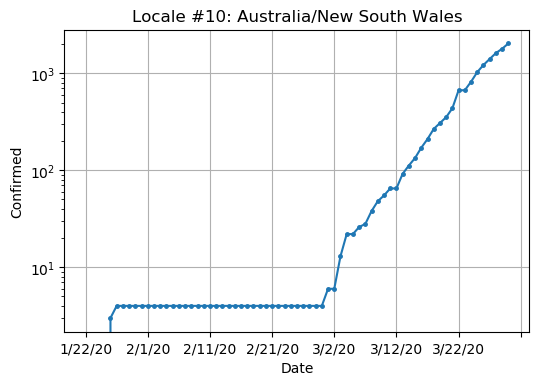

In [123]:
if idx < values.shape[0]:
    while values.iloc[idx, -1] < 1000:
        idx += 1
    plt.figure(dpi=100)
    values.iloc[idx, 1:].plot.line(marker='.', markersize=5, logy=log_metric)
    plt.title('Locale #{idx}: {locale}'.format(idx=idx + 1, locale=values.iloc[idx, 0]))
    plt.xlabel('Date')
    plt.ylabel(metric.capitalize())
    plt.grid(True)
    idx += 1

Stack the data:

In [124]:
values_melt = values.melt(id_vars=['locale'], var_name='date', value_name='value')

In [125]:
values_melt['date'] = pd.to_datetime(values_melt['date'])

In [126]:
values_melt.sample(5)

,locale,date,value
12754,China/Guangdong,2020-03-12,1356
10933,Australia/Queensland,2020-03-05,13
1683,Moldova,2020-01-28,0
12570,Guinea,2020-03-11,0
12186,Burma,2020-03-09,0


Filter by the minimum required metric value:

In [127]:
values_melt = values_melt.loc[values_melt['value'] >= metric_min[metric]]

Apply log to the metric values, if specified:

In [128]:
if log_metric:
    values_melt['value'] = values_melt['value'].map(np.log10)

In [129]:
values_melt.sample(5)

,locale,date,value
15016,Bulgaria,2020-03-21,2.212188
12752,China/Fujian,2020-03-12,2.471292
14781,China/Anhui,2020-03-20,2.995635
15585,Czechia,2020-03-23,3.092018
14543,China/Jiangsu,2020-03-19,2.800029


## Construct Final Datasets

In [130]:
final_schema = pd.DataFrame(columns=['locale', 'date']
                                    + ['value_d{}'.format(idx) for idx in range(-days_history + 1, 1)]
                                    + ['value_d+{}'.format(days_horizon)])

In [131]:
final_schema

,locale,date,value_d-27,value_d-26,value_d-25,value_d-24,value_d-23,value_d-22,value_d-21,value_d-20,value_d-19,value_d-18,value_d-17,value_d-16,value_d-15,value_d-14,value_d-13,value_d-12,value_d-11,value_d-10,value_d-9,value_d-8,value_d-7,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+7


In [132]:
train_to_append_list = []
pred_to_append_list = []

In [133]:
for locale in sorted(values_melt['locale'].unique()):
    values_melt_locale = values_melt.loc[values_melt['locale'] == locale].sort_values('date')
    
    # Add to training data
    for idx in range(values_melt_locale.shape[0] - days_history - days_horizon + 1):
        train_to_append = values_melt_locale.iloc[idx + (days_history - 1), :2].to_dict()
        train_to_append.update(zip(final_schema.columns[2:-1], values_melt_locale['value'].iloc[idx : idx + days_history]))
        train_to_append[final_schema.columns[-1]] = values_melt_locale['value'].iloc[idx + (days_history - 1) + days_horizon]
        train_to_append_list.append(train_to_append)
        
    # Add to prediction data
    if days_history <= values_melt_locale.shape[0]:  # Can only predict if we have enough days of history
        pred_to_append = values_melt_locale.iloc[-1, :2].to_dict()
        pred_to_append.update(zip(final_schema.columns[2:-1], values_melt_locale['value'].iloc[-days_history:]))
        pred_to_append_list.append(pred_to_append)

In [134]:
train = final_schema.append(train_to_append_list, ignore_index=True)
pred = final_schema.append(pred_to_append_list, ignore_index=True)

In [135]:
train.set_index(['locale', 'date'], inplace=True, verify_integrity=True)
pred.set_index(['locale', 'date'], inplace=True, verify_integrity=True)

Check the size of the dataset:

In [136]:
print('The training data has {} samples'.format(train.shape[0]))
print('Predictions will be made for {} locales'.format(pred.shape[0]))

The training data has 583 samples
Predictions will be made for 31 locales


In [137]:
train.head()

value_d-27  value_d-26  value_d-25  value_d-24  \
locale      date                                                         
China/Anhui 2020-02-25    2.181844    2.301030    2.374748    2.472756   
            2020-02-26    2.301030    2.374748    2.472756    2.531479   
            2020-02-27    2.374748    2.472756    2.531479    2.610660   
            2020-02-28    2.472756    2.531479    2.610660    2.681241   
            2020-02-29    2.531479    2.610660    2.681241    2.724276   

                        value_d-23  value_d-22  value_d-21  value_d-20  \
locale      date                                                         
China/Anhui 2020-02-25    2.531479    2.610660    2.681241    2.724276   
            2020-02-26    2.610660    2.681241    2.724276    2.771587   
            2020-02-27    2.681241    2.724276    2.771587    2.822822   
            2020-02-28    2.724276    2.771587    2.822822    2.865104   
            2020-02-29    2.771587    2.822822    2.865104    2.891537   

                        value_d-19  value_d-18  value_d-17  value_d-16  \
locale      date                                                         
China/Anhui 2020-02-25    2.771587    2.822822    2.865104    2.891537   
            2020-02-26    2.822822    2.865104    2.891537    2.919078   
            2020-02-27    2.865104    2.891537    2.919078    2.934498   
            2020-02-28    2.891537    2.919078    2.934498    2.948902   
            2020-02-29    2.919078    2.934498    2.948902    2.959041   

                        value_d-15  value_d-14  value_d-13  value_d-12  \
locale      date                                                         
China/Anhui 2020-02-25    2.919078    2.934498    2.948902    2.959041   
            2020-02-26    2.934498    2.948902    2.959041    2.970347   
            2020-02-27    2.948902    2.959041    2.970347    2.977724   
            2020-02-28    2.959041    2.970347    2.977724    2.983175   
            2020-02-29    2.970347    2.977724    2.983175    2.988113   

                        value_d-11  value_d-10  value_d-9  value_d-8  \
locale      date                                                       
China/Anhui 2020-02-25    2.970347    2.977724   2.983175   2.988113   
            2020-02-26    2.977724    2.983175   2.988113   2.992111   
            2020-02-27    2.983175    2.988113   2.992111   2.993877   
            2020-02-28    2.988113    2.992111   2.993877   2.994317   
            2020-02-29    2.992111    2.993877   2.994317   2.994757   

                        value_d-7  value_d-6  value_d-5  value_d-4  value_d-3  \
locale      date                                                                
China/Anhui 2020-02-25   2.992111   2.993877   2.994317   2.994757   2.995196   
            2020-02-26   2.993877   2.994317   2.994757   2.995196   2.995196   
            2020-02-27   2.994317   2.994757   2.995196   2.995196   2.995196   
            2020-02-28   2.994757   2.995196   2.995196   2.995196   2.995196   
            2020-02-29   2.995196   2.995196   2.995196   2.995196   2.995196   

                        value_d-2  value_d-1  value_d0  value_d+7  
locale      date                                                   
China/Anhui 2020-02-25   2.995196   2.995196  2.995196   2.995635  
            2020-02-26   2.995196   2.995196  2.995196   2.995635  
            2020-02-27   2.995196   2.995196  2.995196   2.995635  
            2020-02-28   2.995196   2.995196  2.995635   2.995635  
            2020-02-29   2.995196   2.995635  2.995635   2.995635

In [138]:
pred.head()

,,value_d-27,value_d-26,value_d-25,value_d-24,value_d-23,value_d-22,value_d-21,value_d-20,value_d-19,value_d-18,value_d-17,value_d-16,value_d-15,value_d-14,value_d-13,value_d-12,value_d-11,value_d-10,value_d-9,value_d-8,value_d-7,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+7
locale,date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
China/Anhui,2020-03-30,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,NaN
China/Beijing,2020-03-30,2.617000,2.621176,2.621176,2.625312,2.629410,2.631444,2.631444,2.632457,2.638489,2.638489,2.639486,2.640481,2.645422,2.655138,2.658965,2.671173,2.681241,2.691081,2.702431,2.717671,2.729974,2.746634,2.748963,2.752816,2.755112,2.758155,2.761176,2.761176,NaN
China/Chongqing,2020-03-30,2.760422,2.760422,2.760422,2.760422,2.760422,2.760422,2.760422,2.760422,2.760422,2.760422,2.760422,2.760422,2.760422,2.760422,2.760422,2.760422,2.760422,2.760422,2.760422,2.761176,2.761928,2.761928,2.761928,2.761928,2.761928,2.761928,2.762679,2.762679,NaN
China/Fujian,2020-03-30,2.471292,2.471292,2.471292,2.471292,2.471292,2.471292,2.471292,2.471292,2.471292,2.471292,2.471292,2.471292,2.471292,2.471292,2.471292,2.471292,2.471292,2.475671,2.481443,2.495544,2.495544,2.502427,2.507856,2.515874,2.519828,2.527630,2.528917,2.531479,NaN
China/Guangdong,2020-03-30,3.130334,3.130334,3.130655,3.130977,3.130977,3.130977,3.130977,3.131298,3.132260,3.132260,3.132260,3.132260,3.133539,3.133858,3.134814,3.136721,3.139249,3.144574,3.146128,3.150142,3.150756,3.154728,3.156246,3.160769,3.163161,3.166430,3.168792,3.171434,NaN


Shuffle the training data:

In [139]:
train = train.sample(frac=1, random_state=random_state)

## Maching Learning

In [140]:
model = linear_model.LassoCV(
    eps=1e-8,
    fit_intercept=True,
    max_iter=100000,
    verbose=False,
    n_jobs=-1,
    random_state=random_state,
)

In [141]:
model.fit(train.iloc[:, :-1], train.iloc[:, -1])

C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017844191412421676, tolerance: 0.017352971806935638
  tol, rng, random, positive)
C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01933041536457286, tolerance: 0.01844744574311503
  tol, rng, random, positive)
C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019988663261924708, tolerance: 0.01844744574311503
  tol, rng, random, positive)
C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. Y

C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018481573001356243, tolerance: 0.017352971806935638
  tol, rng, random, positive)
C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01883413918547165, tolerance: 0.017352971806935638
  tol, rng, random, positive)
C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019083414323808084, tolerance: 0.017352971806935638
  tol, rng, random, positive)


LassoCV(alphas=None, copy_X=True, cv=None, eps=1e-08, fit_intercept=True,
        max_iter=100000, n_alphas=100, n_jobs=-1, normalize=False,
        positive=False, precompute='auto', random_state=0, selection='cyclic',
        tol=0.0001, verbose=False)

In [142]:
model.coef_

array([ 3.05151011e-02,  0.00000000e+00,  0.00000000e+00,  1.70152664e-02,
        2.51069316e-03, -2.33008848e-02, -1.50387649e-02, -7.39781086e-02,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        2.08502837e-02, -0.00000000e+00, -9.78436589e-03, -0.00000000e+00,
        5.16747426e-02,  3.25254369e-02,  0.00000000e+00,  3.10629608e-04,
        3.01530186e-02,  2.50881828e-01,  1.38955257e-02, -1.46942496e+00,
       -6.14556498e-01, -1.39427455e-01,  9.49859371e-01,  1.94086830e+00])

In [143]:
model.intercept_

0.018184199813001456

In [144]:
model.alpha_

3.5672768089125385e-06

In [145]:
min(model.alphas_), max(model.alphas_)

(3.65121847762295e-09, 0.36512184776229484)

In [146]:
model.n_iter_

45380

Cross-validated mean absolute error:

In [147]:
mean_abs_errors = -model_selection.cross_val_score(
    estimator=linear_model.Lasso(
        alpha=model.alpha_,
        max_iter=100000,
        random_state=random_state,
    ),
    X=train.iloc[:, :-1],
    y=train.iloc[:, -1],
    scoring='neg_mean_absolute_error',
)

In [148]:
days_history, metric_min[metric], train.shape[0]

(28, 128, 583)

In [149]:
mean_abs_errors.mean()

0.008335385135155476

In [150]:
mean_abs_errors.min(), mean_abs_errors.max()

(0.006006768615816736, 0.012961574876738944)

## Predictions

In [151]:
pred['value_d+{}'.format(days_horizon)] = model.predict(pred.iloc[:, :-1])

In [152]:
if log_metric:
    for col in pred.columns:
        pred[col] = pred[col].map(lambda x: round(10**x))

In [153]:
pred

,,value_d-27,value_d-26,value_d-25,value_d-24,value_d-23,value_d-22,value_d-21,value_d-20,value_d-19,value_d-18,value_d-17,value_d-16,value_d-15,value_d-14,value_d-13,value_d-12,value_d-11,value_d-10,value_d-9,value_d-8,value_d-7,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+7
locale,date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
China/Anhui,2020-03-30,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,1001
China/Beijing,2020-03-30,414,418,418,422,426,428,428,429,435,435,436,437,442,452,456,469,480,491,504,522,537,558,561,566,569,573,577,577,600
China/Chongqing,2020-03-30,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576,577,578,578,578,578,578,578,579,579,589
China/Fujian,2020-03-30,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,299,303,313,313,318,322,328,331,337,338,340,360
China/Guangdong,2020-03-30,1350,1350,1351,1352,1352,1352,1352,1353,1356,1356,1356,1356,1360,1361,1364,1370,1378,1395,1400,1413,1415,1428,1433,1448,1456,1467,1475,1484,1545
China/Guangxi,2020-03-30,252,252,252,252,252,252,252,252,252,252,252,252,252,252,253,253,253,254,254,254,254,254,254,254,254,254,254,254,258
China/Guizhou,2020-03-30,146,146,146,146,146,146,146,146,146,146,146,146,146,146,147,146,146,146,146,146,146,146,146,146,146,146,146,146,149
China/Hainan,2020-03-30,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,171
China/Hebei,2020-03-30,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,319,319,319,319,319,319,319,319,321,328
